In [2]:
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
from tensorflow.keras.layers import Layer
from sklearn.cluster import KMeans
import tensorflow as tf

class CenterLoss(Layer):
    def __init__(self, num_classes, feature_dim, alpha=0):
        super().__init__()
        self.alpha = alpha
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.centroids = tf.Variable(tf.zeros([num_classes, feature_dim]), dtype=tf.float32, trainable=False)

    def call(self, x, labels):
        centers_batch = tf.gather(self.centroids, tf.argmax(labels, axis=-1))
        diff = x - centers_batch

        intra_class_dist = tf.reduce_sum(tf.square(diff), axis=-1)
        self.add_loss(tf.reduce_mean(intra_class_dist))
        return x

def classification_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 10])
    y_pred = y_pred[:, :10]
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def center_aligned_loss(y_true, y_pred):
    return center_loss_layer(y_pred, y_true)

In [7]:
import keras.utils
from keras.models import load_model

# Custom layer로 딕셔너리 생성
custom_objects = {'CenterLoss': CenterLoss, 'classification_loss' : classification_loss, 'center_aligned_loss' : center_aligned_loss}

# 원하는 모델 불러오기
with keras.utils.custom_object_scope(custom_objects):
    model = load_model('./Center_Loss_0.878.h5')

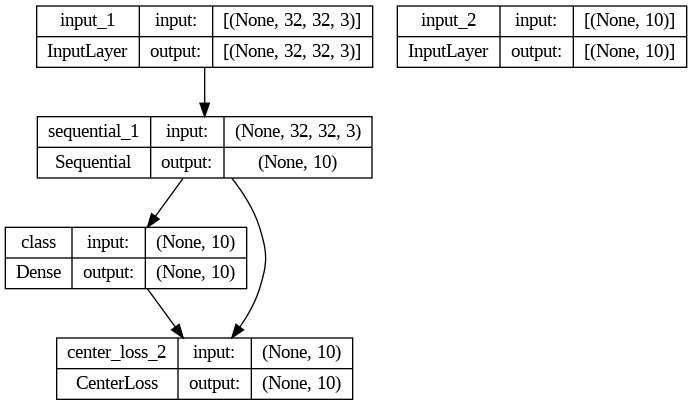

In [8]:
import keras
keras.utils.plot_model(model, show_shapes=True)

# Grad-Cam을 사용한 Heatmap

In [54]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from collections import defaultdict

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images.astype('float32') / 255
train_labels = train_labels.flatten()

test_images = test_images.astype('float32') / 255
test_labels = test_labels.flatten()

n_images_per_class = 1
image_indices_dict = defaultdict(list)

for idx, label in enumerate(test_labels):
    if len(image_indices_dict[label]) < n_images_per_class:
        image_indices_dict[label].append(idx)
    if all(len(images) == n_images_per_class for images in image_indices_dict.values()):
        break

In [55]:
def overlay_heatmap_on_image(img, heatmap):
    img = np.array(img, dtype=np.uint8)
    heatmap_img = cv2.resize(heatmap, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    heatmap_img = np.uint8(255 * heatmap_img)
    heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
    heatmap_img = cv2.addWeighted(img, 0.6, heatmap_img, 0.4, 0)

    return heatmap_img

In [56]:
import numpy as np
import cv2
import tensorflow as tf

def grad_cam(model, target_img, layer_name, label_index):
    cls = np.argmax(label_index)
    target_img_tensor = tf.constant(np.expand_dims(target_img, axis=0))

    with tf.GradientTape() as tape:
        inputs = tf.cast(target_img_tensor, tf.float32)
        tape.watch(inputs)
        
        act_map_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
        conv_outputs, predictions = act_map_model(inputs)
        
        loss = predictions[:, cls]

    grads = tape.gradient(loss, conv_outputs)

    if(grads is not None):
        weights = np.mean(grads.numpy(), axis=(1, 2))
    else:
        raise ValueError('Gradient is None. Please check the code.')

    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[1:3])
    for i, w in enumerate(weights[0]):
        cam += w * conv_outputs[0, :, :, i]

    cam = np.maximum(cam, 0)
    max_cam = np.max(cam)
    if max_cam != 0:
        heatmap = cam / max_cam
    else:
        heatmap = cam

    return heatmap

<br>
<br>

**display_multiple_heatmaps() 함수는 여러 개의 이미지에 대해 Grad-CAM 히트맵을 생성하고, 이를 원본 이미지와 함께 그리드 형태로 표시해주는 함수입니다.**

처리 과정:

1. 이미지 인덱스 및 알맞은 파일 경로를 활용하여 이미지와 해당 레이블 인덱스를 가져옴
2. grad_cam() 함수를 사용하여 히트맵 생성
3. 히트맵을 원본 이미지의 크기에 맞게 크기 조정 및 normalization
4. 원본 이미지에 히트맵을 겹쳐서 시각화 이미지 생성
5. 그리드 형태로 원본 이미지와 겹친 이미지를 표시하고, 빈 서브플롯을 숨김
6. 이미지를 출력

<br>

이 함수를 사용하여 여러 이미지의 히트맵을 한 번에 확인하고, 원하는 클래스의 모델 활성화 영역을 시각적으로 분석하고 비교할 수 있습니다. 차례대로 호출된 이미지를 시각적으로 확인할 수 있습니다.

In [64]:
import matplotlib.pyplot as plt

def display_multiple_heatmaps(model, layer_name, test_images, test_labels, image_indices_dict):
    n_classes = len(np.unique(test_labels))
    n_images_per_class = 1
    figsize = 15
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    fig, axes = plt.subplots(n_images_per_class * 2, n_classes, figsize=(figsize, figsize))

    # 간격 조절
    plt.subplots_adjust(wspace=0.2, hspace=-0.9)

    for class_idx in image_indices_dict.keys():
        for img_idx in range(n_images_per_class):
            current_image_index = image_indices_dict[class_idx][img_idx]
            label_index = test_labels[current_image_index]
            target_img = test_images[current_image_index]

            heatmap = grad_cam(model, target_img, layer_name, label_index)
            heatmap_img = overlay_heatmap_on_image(target_img * 255, heatmap)

            # 원본 이미지 출력 (기존 이미지와 히트맵 이미지를 번갈아 출력)
            axes[img_idx * 2, int(class_idx)].imshow(target_img)
            if img_idx == 0:
                axes[img_idx * 2, int(class_idx)].set_title(class_names[class_idx])

            # 히트맵 이미지 출력 (기존 이미지 바로 다음 행에 출력)
            axes[img_idx * 2 + 1, int(class_idx)].imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB) / 255.0)

            # 좌표값(x, y 방향)을 없애기
            axes[img_idx * 2, int(class_idx)].set_xticks([])
            axes[img_idx * 2, int(class_idx)].set_yticks([])
            axes[img_idx * 2 + 1, int(class_idx)].set_xticks([])
            axes[img_idx * 2 + 1, int(class_idx)].set_yticks([])

    plt.show()

In [65]:
# 이미지 인덱스와 경로 설정하기
custom_image_indices = [382, 836, 149, 456, 32, 488, 309, 87, 310, 734]  # 각 클래스별 선택하려는 이미지 인덱스

# 각 클래스별 선택 이미지를 image_indices_dict에 지정하기
for i, img_idx in enumerate(custom_image_indices):
    image_indices_dict[i] = [img_idx]

# 선택한 이미지 파일로 저장하기
filepaths_dict = {i: [] for i in range(10)}

for label in image_indices_dict.keys():
    image_indices = image_indices_dict[label]
    filepaths_dict[label] = [f'test_image_{index}.jpg' for index in image_indices]

    for i, index in enumerate(image_indices):
        image_array = test_images[index] * 255
        image_array = image_array.astype(np.uint8)
        cv2.imwrite(filepaths_dict[label][i], cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))


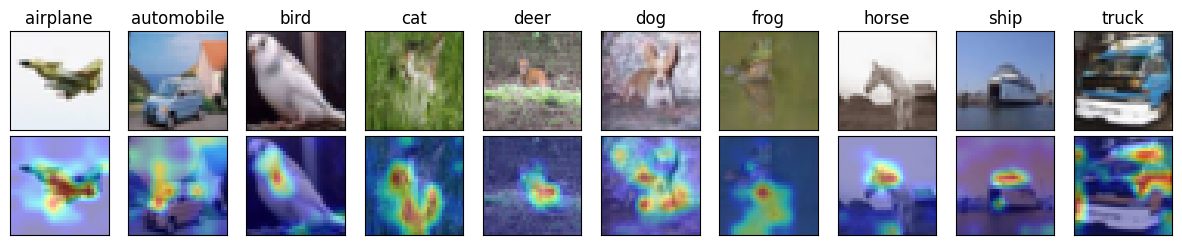

In [66]:
# sequential_1으로부터 모델 생성
sequential_1 = model.get_layer('sequential_1')
new_model = tf.keras.models.Model(sequential_1.input, sequential_1.output)

# 기존 함수 호출
display_multiple_heatmaps(new_model, 'conv2d_4', test_images, test_labels, image_indices_dict)

**히트맵(Heatmap)은 데이터의 상대적인 크기나 값을 색상의 강도로 나타내어 시각화하는 그래프입니다.** 히트맵은 데이터의 분포와 패턴을 한눈에 파악하기 쉽게 하여, 데이터 분석에 많이 사용됩니다.

Grad-CAM 히트맵에서 사용되는 색상은 일반적으로 JET 컬러맵(colormap)을 따릅니다. JET 컬러맵의 색상 의미는 다음과 같습니다.

- **`파란색`** : 낮은 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 거의 기여하지 않음을 의미합니다. 모델이 이 영역을 해당 클래스와 관련이 거의 없는 것으로 간주합니다.

- **`청록색`** : 낮은 중간 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 약간의 기여를 함을 나타냅니다.

- **`녹색`** : 중간 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 중간 정도의 기여를 내고 있음을 의미합니다.

- **`노란색`** : 높은 중간 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 높은 정도의 기여를 내고 있음을 나타냅니다.

- **`빨간색`** : 높은 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스의 확률에 매우 큰 기여를 함을 의미합니다. 이러한 영역은 특히 해당 클래스를 판별하는 데 중요한 부분이며, 모델에 큰 영향을 미칩니다.

<br>

간단히 말해, Grad-CAM 히트맵에서의 색상은 높은 값을 빨간색으로, 낮은 값을 파란색으로 표시하는 방식으로, 각 색상이 CNN 모델에서 특정 클래스에 대한 기여도를 나타냅니다. 이를 통해 모델이 이미지 영역별로 어느 정도 중요하게 여기는지 한눈에 파악할 수 있습니다. 이렇게 시각적으로 분석한 결과를 바탕으로 모델 성능 개선의 방향성을 도출할 수 있습니다.